# The demonstration of the tropical rainfall diagnostic for high-resolution data

### Content


1. [The load of packages, modules, and data](#1-load-of-packages-modules-and-data)

2. [Calculation of histograms]()

3. [Comparison of histograms](#2-comparison-of-histograms)

[Go to the end of file](#the-end)

We split the function to calculate the histogram and the demonstration because the initial function to calculate the histogram has a big memory overhead, and this overhead is significant for high-resolution data. 

The histogram calculations for low-resolution data have more features. Namely, the description of the functionality is following:

|  | Low-resolution | High-resolution |
| --- | --- | --- |
| name of function | histogram_lowres   | histogram|
| uniform binning | + | + |
| non-uniform (log-spaced) binning | + | - |
| lazy (or delayed) mode | + | - |
|  weights (weights=reader.grid_area) | + | - |

In the following deliverable of the diagnostic, we will provide the unique function for data with any grid that wil contain all necessary features for high-resolution data (like non-uniform binning).

#

## 1. The load of packages, modules, and data

In [4]:
import sys
from aqua import Reader
sys.path.insert(0, '../../')
from tropical_rainfall import Tropical_Rainfall

In [1]:
from aqua.slurm import slurm

In [3]:
slurm.max_resources_per_node(queue='compute')

('251.3671875 GB', '8:00:00', '256', '8', '16', '2')

##### Initialization of the diagnostic

In [2]:
factor = 20
diag = Tropical_Rainfall(trop_lat=15,  num_of_bins = 20*factor, first_edge = 0, width_of_bin = 20e-05/factor)

In [ ]:
reader = Reader(model="ICON", exp="ngc3028", source="PT3H", zoom=10,  regrid="r010")
data_icon = reader.retrieve()
data_icon_reg = reader.regrid(data_icon.isel(time=slice(0, 10)))


In [3]:
# Please change the path to the NetCDF files and the PDF files to your own path

path_to_netcdf = "/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/"
path_to_pdf    = "/work/bb1153/b382267/tropical_rainfall_cicle3/PDF/"

In [15]:
hist_icon_ngc3028 = diag.histogram(data_icon_reg, path_to_histogram=path_to_netcdf, name_of_file="icon_ngc3028_PT3H_r10_3h", threshold=20)

10800000 data size after preprocessing
10800000 sum of counts


2023-07-13 01:25:40 :: create_folder :: WARNING  -> Folder /work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/ already exists


The difference between the mean of the data and the mean of the histogram is 10.1413%
The mean of the data is 4.415060126831947e-05 and the mean of the histogram is 4.597310092592593e-05kg m**-2 s**-1.


In [19]:
reader                  = Reader(model="IFS", exp="tco2559-ng5-cycle3", source="2D_1h_native",  regrid="r010")
data_ifs_tco2559_ng5    = reader.retrieve()
data_ifs_tco2559_ng5    = reader.regrid(data_ifs_tco2559_ng5.isel(time=slice(0, 10)))

2023-07-13 01:32:34 :: Reader :: WARNING  -> Duplicate entries found along the time axis, keeping the first one.


In [20]:
hist_ifs_tco2559_ng5 = diag.histogram(data_ifs_tco2559_ng5, threshold=20)
    #path_to_histogram=path_to_netcdf, name_of_file="icon_ngc3028_PT3H_r10_3h", 
    #fs2 = reader.regrid(data_ifs2)

10800000 data size after preprocessing
10800000 sum of counts
The difference between the mean of the data and the mean of the histogram is 10.5574%
The mean of the data is 3.025657871397376e-05 and the mean of the histogram is 3.1593861111111115e-05kg m**-2 s**-1.


{<Axes: xlabel='Precipitation, [mm/day]', ylabel='PDF'>,
 <Figure size 640x400 with 1 Axes>}

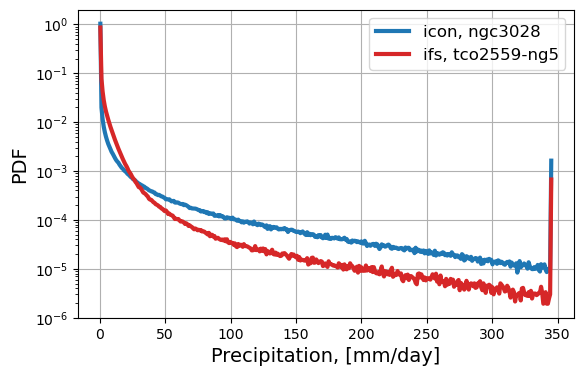

In [23]:
add = diag.histogram_plot(hist_icon_ngc3028,    figsize=0.8, 
                new_unit="mm/day",
                legend='icon, ngc3028')
diag.histogram_plot(hist_ifs_tco2559_ng5,       add = add,  color ='tab:red', 
                new_unit="mm/day",
                legend='ifs, tco2559-ng5') 

In [24]:
reader                  = Reader(model="IFS", exp="tco1279-orca025-cycle3", source="2D_1h_native", regrid="r010")
data_tco1279_orca025    = reader.retrieve()
data_tco1279_orca025    = reader.regrid(data_tco1279_orca025.isel(time=slice(0, 10)))


In [26]:
hist_ifs_tco1279_orca025 = diag.histogram(data_tco1279_orca025, threshold=20)

10800000 data size after preprocessing
10800000 sum of counts
The difference between the mean of the data and the mean of the histogram is 8.3253%
The mean of the data is 3.726494776474608e-05 and the mean of the histogram is 4.001578518518518e-05kg m**-2 s**-1.


{<Axes: xlabel='Precipitation, [mm/day]', ylabel='PDF'>,
 <Figure size 640x400 with 1 Axes>}

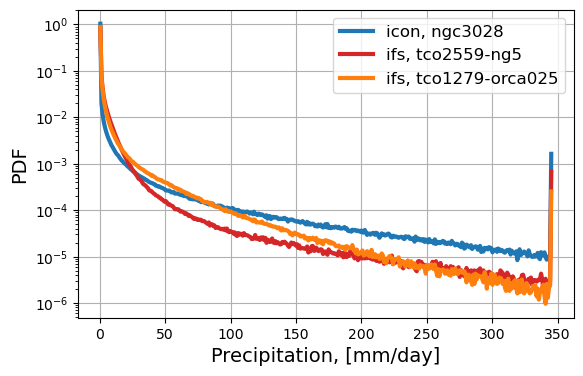

In [27]:
add = diag.histogram_plot(hist_icon_ngc3028,    figsize=0.8, 
                new_unit="mm/day",
                legend='icon, ngc3028')
diag.histogram_plot(hist_ifs_tco2559_ng5,       add = add,  color ='tab:red', 
                new_unit="mm/day",
                legend='ifs, tco2559-ng5') 
diag.histogram_plot(hist_ifs_tco1279_orca025,   add = add,  color ='tab:orange', 
                new_unit="mm/day",
                legend='ifs, tco1279-orca025') 

In [42]:
reader                  = Reader(model="MSWEP", exp="past", source="3hourly")
mswep_retrieved         = reader.retrieve()
mswep_retrieved         = mswep_retrieved.isel(time=slice(9, 10)) #reader.regrid(mswep_retrieved.isel(time=slice(0, 10)))

In [43]:
hist_mswep_3h = diag.histogram(mswep_retrieved, threshold=20)

1080000 data size after preprocessing
1080000 sum of counts
The difference between the mean of the data and the mean of the histogram is nan%
The mean of the data is nan and the mean of the histogram is 0.00044144315740740744kg m**-2 s**-1.


In [5]:
from aqua.slurm import slurm 

In [14]:
slurm.job(cores=16, memory="250 GB")

2023-07-14 06:19:01 :: create_folder :: WARNING  -> Folder ./slurm already exists
2023-07-14 06:19:01 :: create_folder :: WARNING  -> Folder ./slurm/logs already exists
2023-07-14 06:19:01 :: create_folder :: WARNING  -> Folder ./slurm/output already exists
/work/bb1153/b382267/mamba_dir/mambaforge/envs/aqua/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39005 instead
  warnings.warn(
2023-07-14 06:19:01 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=16
#SBATCH --mem=233G
#SBATCH -t 02:30:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382267/mamba_dir/mambaforge/envs/aqua/bin/python -m distributed.cli.dask_worker tcp://136.172.124.1:33125 --nthreads 4 --nworkers 4 --memory-limit 58.21GiB --name dummy-

#### ICON, ngc3028, lra

In [15]:
slurm.squeue()

JOBID      CPUS  NODES ST         NAME                 TIME       START_TIME           DEPENDENCY           PARTITION            MIN_MEMORY          
5988769    256   1     CG         dask-worker          5:53       2023-07-14T06:12:53  (null)               compute              233G                
5988858    16    1     PD         dask-worker          0:00       N/A                  (null)               compute              233G                
5987446    256   1     R          ifs                  2:33:27    2023-07-14T03:45:39  (null)               compute              500G                


0

In [16]:
slurm.scancel(Job_ID=5965275)

##### For big datasets, it is better to calculate and store the histograms by months instead of the full-time range of the dataset. 

The main reasons for that are the following:
- The user can easily keep track of precipitation from a specific season. 
- To keep calculations safe from Runtime errors and memory issues. 

In the current stage of tropical-rainfall diagnostics, we use a streaming-aqua mode in order to split the input data over months. 

#### IFS, tco1279-orca025-cycle3

The bottleneck in the histogram calculation is the necessity to regrid the data and modify the frequency of the original data. 

In [17]:
reader              = Reader(model="IFS", exp="tco1279-orca025-cycle3", source="2D_1h_native", regrid="r010")
ifs_tco1279_orca025_retrived = reader.retrieve()
ifs_tco1279_orca025_retrived.time

<xarray.DataArray 'time' (time: 43393)>
array(['2020-01-20T00:00:00.000000000', '2020-01-20T01:00:00.000000000',
       '2020-01-20T02:00:00.000000000', ..., '2024-12-31T22:00:00.000000000',
       '2024-12-31T23:00:00.000000000', '2025-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01

In [18]:
for year in range(2020, 2026):
    for x in range(6, 12):
        ifs_tco1279_orca025 = ifs_tco1279_orca025_retrived.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        ifs_tco1279_orca025 = reader.timmean(ifs_tco1279_orca025, freq="3H")
        ifs_tco1279_orca025 = reader.regrid(ifs_tco1279_orca025)
        diag.histogram(ifs_tco1279_orca025, path_to_histogram=path_to_netcdf, threshold = 30, 
                     name_of_file="ifs_tco1279_orca025_3hourly_2D_1h_native_r010_3h")

#### IFS, tco2559_ng5

In [ ]:
reader                      = Reader(model="IFS", exp="tco2559-ng5-cycle3", source="2D_1h_native",  regrid="r010")
data_ifs_tco2559_ng5_ret    = reader.retrieve()

for year in range(2020, 2026):
    for x in range(1, 12):
        data_ifs_tco2559_ng5 = data_ifs_tco2559_ng5_ret.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        data_ifs_tco2559_ng5 = reader.timmean(data_ifs_tco2559_ng5, freq="3H")
        data_ifs_tco2559_ng5 = reader.regrid(data_ifs_tco2559_ng5)
        diag.histogram(data_ifs_tco2559_ng5, path_to_histogram=path_to_netcdf, threshold = 30, 
                     name_of_file="ifs_tco1279_orca025_3hourly_2D_1h_native_r010_3h")

#### ICON

In [8]:
diag = Tropical_Rainfall(trop_lat=15,  num_of_bins = 1000, first_edge = 0, width_of_bin = 1)

In [16]:
reader = Reader(model="ICON", exp="ngc3028", source="PT3H", zoom=10,  regrid="r010")
data_icon3028_retrieved = reader.retrieve()
#data_icon3028_retrieved.time

path_to_netcdf ="/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/PT3H/"

for year in range(2021, 2026):
    for x in range(1, 6, 2):
        data_icon3028 = data_icon3028_retrieved.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        #data_icon3028 = reader.timmean(data_icon3028, freq="3H")
        data_icon3028 = data_icon3028['tprate'][:]*86400
        data_icon3028 = reader.regrid(data_icon3028)
        diag.histogram(data_icon3028, path_to_histogram=path_to_netcdf, 
                     name_of_file="icon3028_tco1279_PT3H_r010_3h")

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-2325133' coro=<Client._gather.<locals>.wait() done, defined at /work/bb1153/b382267/mamba_dir/mambaforge/envs/aqua/lib/python3.10/site-packages/distributed/client.py:2196> exception=AllExit()>
Traceback (most recent call last):
  File "/work/bb1153/b382267/mamba_dir/mambaforge/envs/aqua/lib/python3.10/site-packages/distributed/client.py", line 2205, in wait
    raise AllExit()
distributed.client.AllExit
/work/bb1153/b382267/AQUA/aqua/reader/reader.py:380: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence t

#### MSWEP 

In [ ]:
reader              = Reader(model="MSWEP", exp="past", source="3hourly")
mswep_retrieved = reader.retrieve()
for year in range(1979, 2020):
    for x in range(1, 12):
        mswep  = mswep_retrieved.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        diag.histogram(mswep, path_to_histogram=path_to_netcdf, 
                     name_of_file="trop_rainfall_mswep_past_3hourly_r010")

## 2. Comparison of histograms

Loading the histograms and combining them by seasons:

In [13]:
path_to_ifs='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/ifs_tco1279_ng5/2020/'
hist_ifs_tco1279_ng5_2020 = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs, multi = None, seasons = False, all = True)

In [14]:
path_to_ifs='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/ifs_tco1279_orca025_new/2020/'
#DJF_hist_ifs, MAM_hist_ifs, JJA_hist_ifs, SON_hist_ifs = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs, multi = None, seasons = True, all = False)
hist_ifs_tco1279_orca025_2020 = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs, multi = None, seasons = False, all = True)

In [5]:
#path_to_mswep='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/mswep_past_3hourly/'
#DJF_hist_mswep, MAM_hist_mswep, JJA_hist_mswep, SON_hist_mswep = diag.merge_list_of_histograms(path_to_histograms = path_to_mswep, multi = None, seasons = True, all = False)

In [15]:
path_to_icon='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/icon_ngc3028_PT3H/2020/'
mswep_icon_ngc3028_PT3H_2020 = diag.merge_list_of_histograms(path_to_histograms = path_to_icon, multi = None,  all = True)

#### Below we compare the histograms for ifs data and observations (mswep data) for each season:


Units of precipitation: mm/day

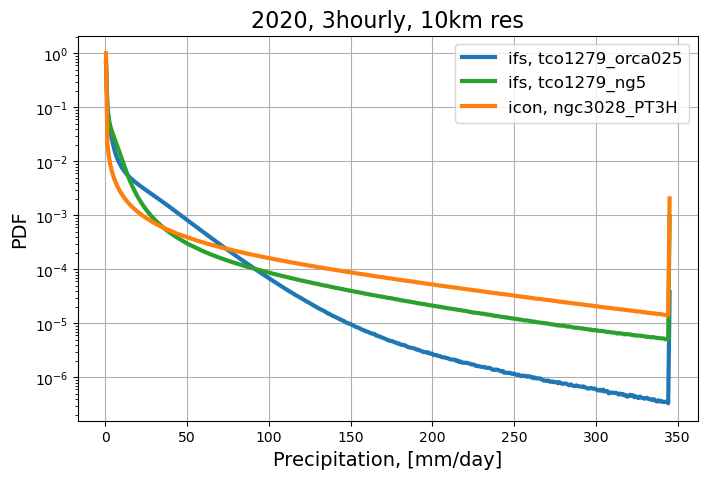

In [16]:
add = diag.histogram_plot(hist_ifs_tco1279_orca025_2020,          legend='ifs, tco1279_orca025', new_unit='mm/day')
add = diag.histogram_plot(hist_ifs_tco1279_ng5_2020,      legend='ifs, tco1279_ng5', new_unit='mm/day', color='tab:green',  add=add)
add = diag.histogram_plot(mswep_icon_ngc3028_PT3H_2020,      legend='icon, ngc3028_PT3H', new_unit='mm/day', color='tab:orange', add=add, 
                          plot_title='2020, 3hourly, 10km res')

In [17]:
path_to_ifs='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/ifs_tco1279_ng5/2020/'
hist_ifs_tco1279_ng5_1month = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs, multi = 1, seasons = False, all = False)

In [18]:
path_to_ifs='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/ifs_tco1279_orca025_new/2020/'
#DJF_hist_ifs, MAM_hist_ifs, JJA_hist_ifs, SON_hist_ifs = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs, multi = None, seasons = True, all = False)
hist_ifs_tco1279_orca025_1month = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs, multi = 1, seasons = False, all = False)

In [19]:
path_to_icon='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/icon_ngc3028_PT3H/2020/'
mswep_icon_ngc3028_PT3H_1month = diag.merge_list_of_histograms(path_to_histograms = path_to_icon, multi = 1,  all = False)

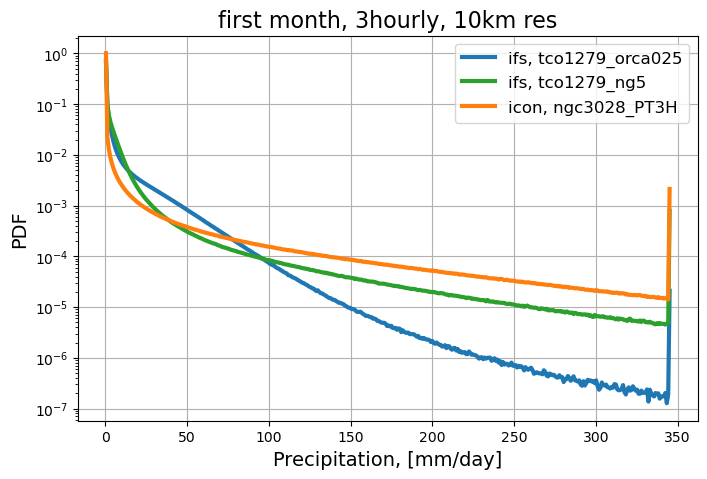

In [21]:
add = diag.histogram_plot(hist_ifs_tco1279_orca025_1month,          legend='ifs, tco1279_orca025', new_unit='mm/day')
add = diag.histogram_plot(hist_ifs_tco1279_ng5_1month,      legend='ifs, tco1279_ng5', new_unit='mm/day', color='tab:green',  add=add)
add = diag.histogram_plot(mswep_icon_ngc3028_PT3H_1month,      legend='icon, ngc3028_PT3H', new_unit='mm/day', color='tab:orange', add=add, 
                          plot_title='first month, 3hourly, 10km res')

#

##### The end